# Preliminary Predictive Modeling

In [251]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay

# from typing import Union, Type, List, Dict
from typing import List, Tuple

pd.set_option("display.max_columns", None)

In [2]:
from pipeline_to_sql import make_postgres_conn

## Functions

In [3]:
def return_dummified_df(df: pd.DataFrame, dummy_columns: List[str], 
        drop_first: bool=False) -> pd.DataFrame:
    return pd.get_dummies(df, columns=dummy_columns, drop_first=drop_first)

In [58]:
def return_X_y_arrays(
        df:pd.DataFrame, y_column: str='death_yn'
        ) -> Tuple[np.ndarray, np.ndarray]:
    X = df.loc[:, df.columns != y_column]
    y = df.loc[:, y_column]
    return X.values, y.values

## Loading data

In [59]:
no_nulls_query = """
            SELECT *
            FROM no_null_data;
            """

In [60]:
conn = make_postgres_conn('covid_cases')

In [61]:
df = pd.read_sql(no_nulls_query, conn)
conn.close()

In [62]:
df.head(1)

,case_month,res_state,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,low_income_score,perc_tribal_ct,perc_rural_ct
0,2020-06,KS,"SHAWNEE, KS",20177,18 to 49 years,Female,White,Hispanic/Latino,3.0,0.0,Clinical evaluation,Yes,Laboratory-confirmed case,Symptomatic,No,No,No,No,0.0,0.0,0.023256


In [63]:
df.shape[0]

61650

## Data transformation

In [64]:
df['death_yn'] = np.where(df['death_yn']=='Yes', 1, 0)
df['low_income_score'] = df['low_income_score'].replace(
    [0.0, 7.0, 15.0], ['Low', 'Medium', 'High'])
df['case_month'] = pd.to_datetime(df['case_month']).dt.month_name()

In [65]:
columns_drop = ['res_county', 'county_fips_code', 'process', 'current_status']
columns_dummy = ['case_month', 'res_state', 'age_group', 'sex', 'race', 'ethnicity', 
    'exposure_yn', 'symptom_status', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 
    'low_income_score']

In [66]:
df = df.loc[df['current_status']=='Laboratory-confirmed case', :]

In [67]:
df.reset_index(drop=True, inplace=True)

In [68]:
df.shape[0]

57515

In [69]:
df

,case_month,res_state,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,low_income_score,perc_tribal_ct,perc_rural_ct
0,June,KS,"SHAWNEE, KS",20177,18 to 49 years,Female,White,Hispanic/Latino,3.0,0.0,Clinical evaluation,Yes,Laboratory-confirmed case,Symptomatic,No,No,0,No,Low,0.000000,0.023256
1,December,NV,"CLARK, NV",32003,18 to 49 years,Male,Asian,Hispanic/Latino,0.0,0.0,Routine surveillance,Yes,Laboratory-confirmed case,Symptomatic,No,No,0,Yes,Low,0.014374,0.030801
2,April,OH,"MONTGOMERY, OH",39113,18 to 49 years,Female,White,Hispanic/Latino,0.0,0.0,Clinical evaluation,Yes,Laboratory-confirmed case,Symptomatic,No,No,0,Yes,Medium,0.000000,0.006536
3,June,KS,"SHAWNEE, KS",20177,18 to 49 years,Female,White,Hispanic/Latino,0.0,0.0,Clinical evaluation,Yes,Laboratory-confirmed case,Symptomatic,No,No,0,Yes,Low,0.000000,0.023256
4,April,KS,"LYON, KS",20111,18 to 49 years,Female,White,Hispanic/Latino,0.0,0.0,Multiple,Yes,Laboratory-confirmed case,Symptomatic,No,No,0,Yes,Medium,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57510,March,NV,"CLARK, NV",32003,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Multiple,Yes,Laboratory-confirmed case,Symptomatic,Yes,No,0,Yes,Low,0.014374,0.030801
57511,March,NV,"CLARK, NV",32003,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Multiple,Yes,Laboratory-confirmed case,Symptomatic,No,No,0,Yes,Low,0.014374,0.030801
57512,March,NV,"CLARK, NV",32003,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Routine surveillance,Yes,Laboratory-confirmed case,Symptomatic,No,No,0,Yes,Low,0.014374,0.030801
57513,March,NV,"CLARK, NV",32003,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Multiple,Yes,Laboratory-confirmed case,Symptomatic,No,No,0,Yes,Low,0.014374,0.030801


In [70]:
df.drop(columns=columns_drop, inplace=True)

In [71]:
# for logistic regression: drop_first=True, for random forest: drop_first=False
# return_dummified_df(df, columns_dummy, drop_first=False).head()

## Dummy Classifier

In [93]:
data_rf = return_dummified_df(df, columns_dummy, drop_first=False)

In [94]:
X_rf, y_rf = return_X_y_arrays(data_rf)

In [95]:
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf)

In [96]:
model_dum = DummyClassifier(strategy='stratified')
model_dum.fit(X_rf_train, y_rf_train)

DummyClassifier(strategy='stratified')

In [97]:
y_dum_pred = model_dum.predict(X_rf_test)

In [98]:
recall_score(y_rf_test, y_dum_pred)

0.021604938271604937

## Logistic Regression

In [223]:
data_log = return_dummified_df(df, columns_dummy, drop_first=True)

In [234]:
data_log.shape

(57515, 44)

In [224]:
X_log, y_log = return_X_y_arrays(data_log)

In [225]:
X_log[:, :2]

array([[3., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [226]:
scaler_mms = MinMaxScaler()
scaler_mms.fit(X_log[:, :2])

MinMaxScaler()

In [227]:
X_log[:, :2] = scaler_mms.transform(X_log[:, :2])

In [228]:
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_log)

In [229]:
model_log = LogisticRegression(solver='lbfgs', max_iter=500)

In [230]:
model_log.fit(X_log_train, y_log_train)

LogisticRegression(max_iter=500)

In [231]:
yhat_log = model_log.predict(X_log_test)

In [232]:
recall_score(y_log_test, yhat_log)

0.36645962732919257

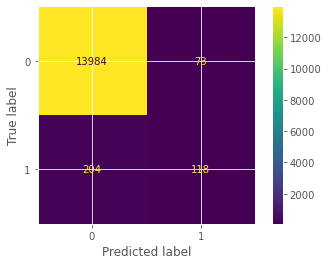

In [253]:
cm_log = confusion_matrix(y_log_test, yhat_log, labels=model_log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=model_log.classes_)
disp.plot();

## Random Forest

In [248]:
X_rf_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [2., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [249]:
y_rf_train

array([0, 0, 0, ..., 0, 0, 0])

In [244]:
model_rf = RandomForestClassifier(n_estimators=100, criterion='gini')

In [245]:
model_rf.fit(X_rf_train, y_rf_train)

RandomForestClassifier()

In [246]:
yhat_rf = model_rf.predict(X_rf_test)

In [247]:
recall_score(y_rf_test, yhat_rf)

0.4228395061728395

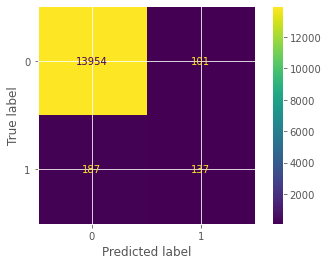

In [252]:
cm_rf = confusion_matrix(y_rf_test, yhat_rf, labels=model_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=model_rf.classes_)
disp.plot();